# Group Assignment QF627

*Group Members:*
* Anna Germine Lim
* Peng Cheng
* Zenith Tay
* Gregory Tan

## Packages Used in This Workbook

In [1]:
## Data Download

import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime

## For Visualisation

## Useful Functions Used in this Sheet

In [2]:
def download_data (ticker: list[str] | str,
                   start_date: str | datetime, 
                   end_date: str | datetime) -> pd.DataFrame:
    data =\
    (
        yf.download(tickers = ticker,
                    start = start_date,
                    end = end_date)
    )

    return data

In [3]:
def generate_returns(price_data: pd.DataFrame,
                     price_col: 'str' = 'Close') -> pd.Series:
    
    returns_series = price_data[price_col].pct_change()
    cum_returns_series = (1 + returns_series).cumprod()

    tot_returns = float(cum_returns_series.iloc[-1].iloc[0])

    print('=== Summary of Returns === \n',
          f'Total Returns = {tot_returns: .2%}'
          )

    return tot_returns, returns_series, cum_returns_series

## Download Dataset

In [4]:
raw_spy_data =\
(
    download_data('SPY',
                  start_date = '2006-11-01',
                  end_date = '2025-11-13')
)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
raw_spy_data

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2006-11-01,95.973587,96.990403,95.875412,96.927293,83005600
2006-11-02,95.917542,96.078827,95.623016,95.728200,60693100
2006-11-03,95.749199,96.345269,95.104047,96.261122,71346400
2006-11-06,96.829132,96.969381,96.036712,96.043731,63303300
2006-11-07,97.200813,97.460274,96.773048,96.913297,63318900
...,...,...,...,...,...
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400


In [6]:
spy_data = \
(
    raw_spy_data
    .droplevel(level = 1,
               axis = 1)
).resample('W-FRI').agg({'Close': 'last', 'High': 'last','Low': 'last'})

In [7]:
spy_data

Price,Close,High,Low
Date,,,
2006-11-03,95.749199,96.345269,95.104047
2006-11-10,96.941338,97.011457,96.576683
2006-11-17,98.470100,98.477109,97.986233
2006-11-24,98.420967,98.764575,98.315773
2006-12-01,98.329842,98.638395,97.453274
...,...,...,...
2025-10-17,664.390015,665.760010,658.140015
2025-10-24,677.250000,678.469971,675.650024
2025-10-31,682.059998,685.080017,679.239990


## Project Start

In [8]:
# data wrangling and preperation
train_pct = 0.75
train_test_split_index = int(train_pct*len(spy_data))
spy_train_data =\
    (
        spy_data
        .copy()
        .iloc[ : train_test_split_index]
    )

spy_test_data =\
    (
        spy_data
        .copy()
        .iloc[train_test_split_index : ]
    )

In [9]:
len(spy_train_data) + len(spy_test_data)

994

In [10]:
spy_test_data

Price,Close,High,Low
Date,,,
2021-02-12,367.603210,367.846612,364.916193
2021-02-19,365.159576,367.359733,364.710174
2021-02-26,356.106140,360.993285,354.111985
2021-03-05,359.167725,360.225674,348.878514
2021-03-12,368.932617,369.073047,366.255000
...,...,...,...
2025-10-17,664.390015,665.760010,658.140015
2025-10-24,677.250000,678.469971,675.650024
2025-10-31,682.059998,685.080017,679.239990


### Part 1

#### Momentum Trading Strategy - Bollinger Band

In [11]:
def setup_bollinger_strategy(
        old_df: pd.DataFrame,
        period: int,
        std_dev: int
) -> pd.DataFrame:
    df = old_df.copy()

    df[f'sma_{period}'] = \
    (
        df['Close']
        .rolling(period)
        .mean()
    )

    df['std_dev'] = \
    (
        df['Close']
        .rolling(period)
        .std()
    )

    df[f'upper_band_{std_dev}sd'] = \
    (
        df[f'sma_{period}'] +
        (
            df['std_dev'] * std_dev
        )
    )

    df[f'lower_band_{std_dev}sd'] = \
    (
        df[f'sma_{period}'] -
        (
            df['std_dev'] * std_dev
        )
    )

    return df

<Axes: xlabel='Date'>

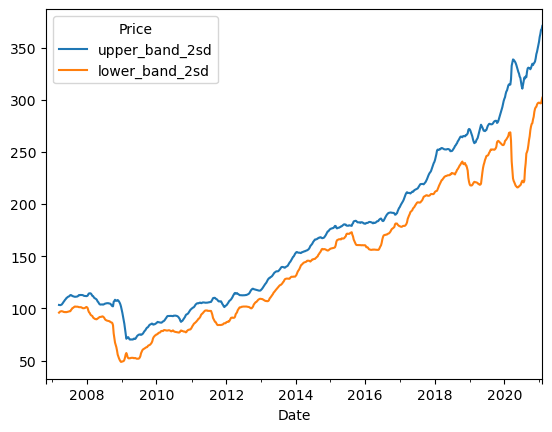

In [12]:
(
    setup_bollinger_strategy(spy_train_data,
                             20,
                             2).iloc[:,-2:]
                             .plot()
)

In [13]:
spy_train_data_bollinger = \
(
    setup_bollinger_strategy(spy_train_data,
                             20,
                             2)
)

In [14]:
def generate_signals(
        old_df: pd.DataFrame
) -> pd.DataFrame:
    df = old_df.copy()
    
    signal = 0

    lst_signal = []

    for index, item in enumerate(df['Close']):
        if index ==0:
            lst_signal.append(0)
            continue
        prev_close = df['Close'].iloc[index-1] 
        close = df['Close'].iloc[index] 
        sma = df['sma_20'].iloc[index]
        lower_band = df['lower_band_2sd'].iloc[index]
        upper_band = df['upper_band_2sd'].iloc[index]

        if signal == 0:
            if (prev_close < lower_band) & (close > lower_band):
                signal = 1
            if (prev_close > upper_band) & (close < upper_band):
                signal = -1
        

        if signal == -1:
            if close < sma:
                signal = 0
        
        if signal == 1:
            if close > sma:
                signal = 0
        lst_signal.append(signal)

    df['signal'] = lst_signal
    df['position'] = \
    (
        df['signal']
        .ffill()
        .shift(1)
        .fillna(0)
        .dropna()
    )
    return df

In [15]:
spy_train_data_bollinger = \
(
    generate_signals(spy_train_data_bollinger)
)

In [16]:
spy_train_data_bollinger

Price,Close,High,Low,sma_20,std_dev,upper_band_2sd,lower_band_2sd,signal,position
Date,,,,,,,,,
2006-11-03,95.749199,96.345269,95.104047,NaN,NaN,NaN,NaN,0,0.0
2006-11-10,96.941338,97.011457,96.576683,NaN,NaN,NaN,NaN,0,0.0
2006-11-17,98.470100,98.477109,97.986233,NaN,NaN,NaN,NaN,0,0.0
2006-11-24,98.420967,98.764575,98.315773,NaN,NaN,NaN,NaN,0,0.0
2006-12-01,98.329842,98.638395,97.453274,NaN,NaN,NaN,NaN,0,0.0
...,...,...,...,...,...,...,...,...,...
2021-01-08,356.948792,357.164107,353.054052,328.430333,15.817250,360.064833,296.795833,0,0.0
2021-01-15,351.743347,353.503444,349.870878,329.741054,16.629462,362.999978,296.482129,0,0.0
2021-01-22,358.465515,359.635808,357.491823,331.759770,17.565085,366.889941,296.629599,0,0.0


In [17]:
def compute_strategy_return(
        old_df: pd.DataFrame
) -> pd.DataFrame:
    df = old_df.copy()


    df['daily_return'] = \
    (
        (
            df['Close']/
            df['Close'].shift(1)
        )
        .apply(np.log)
    )

    df['cum_return'] = \
    (
        df['daily_return']
        .cumsum()
        .apply(np.exp)
    )

    df['strategy_return'] = \
    (
        (
            df['position'] 
            *
            df['daily_return']
        )
        .cumsum()
        .apply(np.exp)
    )

    return df

In [18]:
spy_train_data_bollinger = \
(
    compute_strategy_return(spy_train_data_bollinger)
)

<Axes: xlabel='Date'>

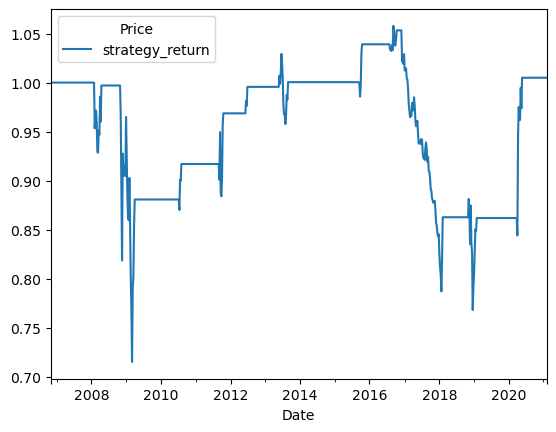

In [19]:
spy_train_data_bollinger[['strategy_return']].plot()

<Axes: xlabel='Date'>

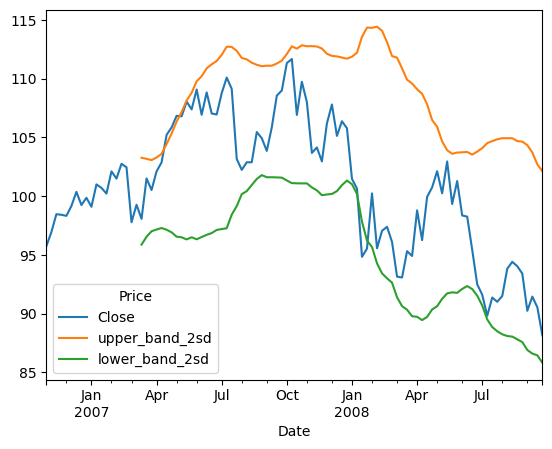

In [20]:
spy_train_data_bollinger[['Close','upper_band_2sd','lower_band_2sd']][:100].plot()

In [21]:
def compute_drawdown(old_df:pd.DataFrame) -> pd.DataFrame:
    df = old_df.copy()

    df['cum_max'] =\
    (
        df['strategy_return']
        .cummax()
    )

    df['drawdown'] = \
    (
        df['cum_max'] -
        df['strategy_return']
    )
    df['in_drawdown'] =\
    (
        df['cum_max'] !=
        df['strategy_return']
    )
    
    return df

In [22]:
spy_train_data_bollinger = \
    (
        compute_drawdown(spy_train_data_bollinger)
    )

In [23]:
spy_train_data_bollinger.iloc[-1]

Price
Close              362.987549
High               363.699096
Low                361.517682
sma_20             336.310696
std_dev             17.201033
upper_band_2sd     370.712763
lower_band_2sd      301.90863
signal                      0
position                  0.0
daily_return         0.046565
cum_return           3.791024
strategy_return      1.004949
cum_max              1.057737
drawdown             0.052788
in_drawdown              True
Name: 2021-02-05 00:00:00, dtype: object

In [27]:
#Run back Testing on Test data
spy_test_data_bollinger = \
(
    setup_bollinger_strategy(spy_test_data,
                            20,
                            2)
)

In [28]:
spy_test_data_bollinger =\
(
    spy_test_data_bollinger
    .pipe(generate_signals)
    .pipe(compute_strategy_return)
    .pipe(compute_drawdown)
)

In [29]:
spy_test_data_bollinger

Price,Close,Volume,sma_20,std_dev,upper_band_2sd,lower_band_2sd,signal,position,daily_return,cum_return,strategy_return,cum_max,drawdown,in_drawdown
Date,,,,,,,,,,,,,,
2021-02-12,367.603180,226577300,NaN,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,True
2021-02-19,365.159546,246216800,NaN,NaN,NaN,NaN,0,0.0,-0.006670,0.993353,1.000000,1.000000,0.0,False
2021-02-26,356.106232,546504300,NaN,NaN,NaN,NaN,0,0.0,-0.025105,0.968725,1.000000,1.000000,0.0,False
2021-03-05,359.167664,640356900,NaN,NaN,NaN,NaN,0,0.0,0.008560,0.977053,1.000000,1.000000,0.0,False
2021-03-12,368.932648,497580800,NaN,NaN,NaN,NaN,0,0.0,0.026825,1.003617,1.000000,1.000000,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-17,664.390015,457106900,634.945508,23.794619,682.534745,587.356271,0,0.0,0.017262,1.807357,1.147994,1.147994,0.0,False
2025-10-24,677.250000,337267400,639.021887,23.704735,686.431358,591.612417,0,0.0,0.019171,1.842340,1.147994,1.147994,0.0,False
2025-10-31,682.059998,374234900,643.445157,23.025969,689.497095,597.393219,0,0.0,0.007077,1.855425,1.147994,1.147994,0.0,False


# Result: Bollinger

<Axes: xlabel='Date'>

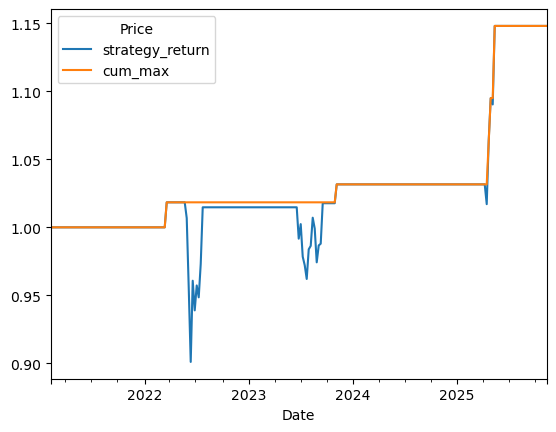

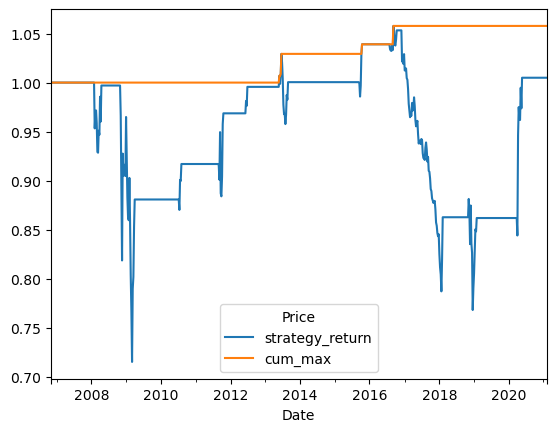

In [30]:
spy_test_data_bollinger[['strategy_return','cum_max']].plot()
spy_train_data_bollinger[['strategy_return','cum_max']].plot()

In [31]:
(spy_test_data_bollinger.iloc[-1,-4] 
-1
*100)

np.float64(-98.85200579804737)

In [32]:
print(
    'Test Return (%): ',(spy_test_data_bollinger.iloc[-1,-4]-1) *100,'\n'
    'Train Return (%): ',(spy_train_data_bollinger.iloc[-1,-4] -1) *100)

Test Return (%):  14.799420195263323 
Train Return (%):  0.4949295246572394


In [33]:
#Parameter Tuning: Bollinger Squeeze; Band Expansion; Breakout

#### Momentum Trading Strategy - RSI with MACD

In [34]:
def RSI(old_df, period=14):
    df = old_df.copy()
    delta = df['Close'].diff().dropna()
    
    u = delta * 0
    d = u.copy()
    
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    
    u[u.index[period - 1]] = np.mean( u[:period] ) # 
    
    u = u.drop(u.index[:(period - 1)
                      ]
              )
    
    d[d.index[period - 1]] = np.mean( d[:period] )
    
    d = d.drop(d.index[:(period - 1)
                      ]
              )
    
    rs = u.ewm(com = period - 1, adjust = False).mean() / \
         d.ewm(com = period - 1, adjust = False).mean()
    
    df['rsi'] = 100 - 100 / (1 + rs)
    return df

In [35]:
def macd(old_df,
        macd_long: int = 26,
        macd_short: int = 12
        ) -> pd.DataFrame:
    
    #MACD - for trend direction
    
    df = old_df.copy()
    
    df['macd_long'] = \
    (    
        df['Close']
        .ewm(span = macd_long,
                adjust = False)
        .mean()
    )

    df['macd_short'] = \
    (
        df['Close']
        .ewm(span = macd_short,
             adjust = False)
        .mean()
    )

    df['macd'] = \
    (
        df['macd_short'] -
        df['macd_long']
    )

    df['signal_line'] = \
    (
        df['macd']
        .ewm(span = 9,
             adjust = False)
        .mean()
    )
    return df


In [36]:
def generate_signals_rsi_macd(
        old_df: pd.DataFrame
) -> pd.DataFrame:
    df = old_df.copy()
    df['signal'] = \
    (
        np
        .select(
            [
                (df['rsi'] > 30) & (df['macd'] > df['signal_line']),
                (df['rsi'] < 70) & (df['macd'] < df['signal_line'])
            ],
            [
                1,
                -1
            ],
            0
        )
    )
    df['position'] = \
    (
        df['signal']
        .ffill()
        .shift(1)
        .fillna(0)
        .dropna()
    )
    return df

In [37]:
spy_train_data_rsi_macd =\
(
    spy_train_data
    .pipe(RSI)
    .pipe(macd)
    .pipe(generate_signals_rsi_macd)
    .pipe(compute_strategy_return)
    .pipe(compute_drawdown)
)

In [38]:
spy_test_data_rsi_macd = \
(
    spy_test_data
    .pipe(RSI)
    .pipe(macd)
    .pipe(generate_signals_rsi_macd)
    .pipe(compute_strategy_return)
    .pipe(compute_drawdown)
)

<Axes: xlabel='Date'>

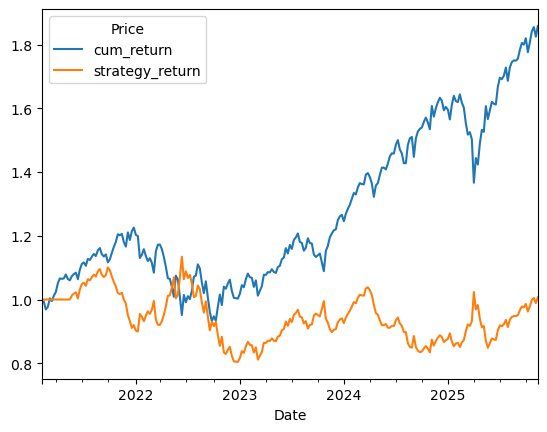

In [39]:
spy_test_data_rsi_macd[['cum_return','strategy_return']].plot()

In [40]:
def setup_buy_new_high(
        old_df,
        num_entry:int,
        num_exit:int) -> pd.DataFrame:
    
    df = old_df.copy()

    df['delta'] =\
    (
        df['Close']
        .diff()
    )

    #exit
    df['consec_min'] = \
    (
        df['delta']
        .rolling(num_exit)
        .min()
    )

    #entry
    df['consec_max'] = \
    (
        df['delta']
        .rolling(num_entry)
        .max()
    )

    df['signal'] = \
    (
        np
        .select(
            [
                df['consec_max'] < 0,
                df['consec_min'] > 0
            ],
            [
                1,
                0
            ],
            np.nan
        )
    )
    #stack buy
    df['position'] = \
    (
        df['signal']
        .ffill()
        .shift(1)
        .cumsum()
        .dropna()
    )
    return df

<Axes: xlabel='Date'>

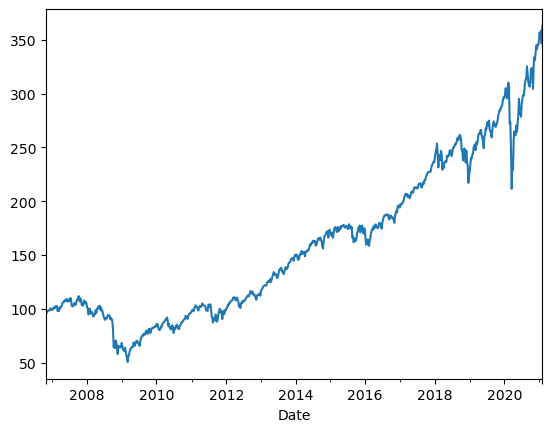

In [41]:
spy_train_data['Close'].plot()

In [42]:
df_ret = pd.DataFrame()

for entry in range(2,50):
    for exit in range(2,50):
        a = spy_train_data.copy()
        a = \
        (
            setup_buy_new_high(a,entry,exit)
            .pipe(compute_strategy_return)
            .pipe(compute_drawdown)
        )
        df_ret[f'stra_ret_entry{entry}_exit{exit}'] = a[['strategy_return']].copy()
df_ret['buy_and_hold'] = a['cum_return'].copy()

/var/folders/kq/kp3tn0x514j_28q4zs2vmyx80000gn/T/ipykernel_1164/2084094826.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ret[f'stra_ret_entry{entry}_exit{exit}'] = a[['strategy_return']].copy()
/var/folders/kq/kp3tn0x514j_28q4zs2vmyx80000gn/T/ipykernel_1164/2084094826.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ret[f'stra_ret_entry{entry}_exit{exit}'] = a[['strategy_return']].copy()
/var/folders/kq/kp3tn0x514j_28q4zs2vmyx80000gn/T/ipykernel_1164/2084094826.py:12: PerformanceWarning: DataFrame is highly frag

In [43]:
df_ret.iloc[-1].sort_values(ascending=False).head(20)

stra_ret_entry2_exit36    1.240953e+297
stra_ret_entry2_exit39    1.240953e+297
stra_ret_entry2_exit28    1.240953e+297
stra_ret_entry2_exit30    1.240953e+297
stra_ret_entry2_exit31    1.240953e+297
stra_ret_entry2_exit32    1.240953e+297
stra_ret_entry2_exit33    1.240953e+297
stra_ret_entry2_exit34    1.240953e+297
stra_ret_entry2_exit35    1.240953e+297
stra_ret_entry2_exit37    1.240953e+297
stra_ret_entry2_exit38    1.240953e+297
stra_ret_entry2_exit40    1.240953e+297
stra_ret_entry2_exit26    1.240953e+297
stra_ret_entry2_exit41    1.240953e+297
stra_ret_entry2_exit42    1.240953e+297
stra_ret_entry2_exit43    1.240953e+297
stra_ret_entry2_exit44    1.240953e+297
stra_ret_entry2_exit45    1.240953e+297
stra_ret_entry2_exit46    1.240953e+297
stra_ret_entry2_exit47    1.240953e+297
Name: 2021-02-05 00:00:00, dtype: float64

In [44]:
a =\
(
    setup_buy_new_high(

        spy_train_data,
        2,
        2
    )
    .pipe(compute_strategy_return)
    .pipe(compute_drawdown)
)

In [45]:
a.iloc[20:50]

Price,Close,Volume,delta,consec_min,consec_max,signal,position,daily_return,cum_return,strategy_return,cum_max,drawdown,in_drawdown
Date,,,,,,,,,,,,,
2007-03-23,101.514099,524036300,3.440720,-1.199173,3.440720,NaN,10.0,0.034482,1.060209,1.144509,1.144509,0.000000,False
2007-03-30,100.530067,634186800,-0.984032,-0.984032,3.440720,NaN,11.0,-0.009741,1.049931,1.028217,1.144509,0.116292,True
2007-04-06,102.115822,272652200,1.585754,-0.984032,1.585754,NaN,12.0,0.015651,1.066493,1.240651,1.240651,0.000000,False
2007-04-13,102.880478,413774500,0.764656,0.764656,1.585754,0.0,13.0,0.007460,1.074479,1.367001,1.367001,0.000000,False
2007-04-20,105.216721,506895800,2.336243,0.764656,2.336243,0.0,13.0,0.022454,1.098879,1.830383,1.830383,0.000000,False
2007-04-27,105.860954,497093300,0.644234,0.644234,2.336243,0.0,13.0,0.006104,1.105607,1.981552,1.981552,0.000000,False
2007-05-04,106.845062,505325300,0.984108,0.644234,0.984108,0.0,13.0,0.009253,1.115885,2.234848,2.234848,0.000000,False
2007-05-11,106.802544,513142200,-0.042519,-0.042519,0.984108,NaN,13.0,-0.000398,1.115441,2.223314,2.234848,0.011534,True
2007-05-18,108.048546,603182100,1.246002,-0.042519,1.246002,NaN,13.0,0.011599,1.128454,2.585152,2.585152,0.000000,False


In [46]:
a['signal'].value_counts()

signal
0.0    234
1.0    121
Name: count, dtype: int64

In [47]:
a.loc[(a['signal'] == 1.0) & (a['position'] != 1.0)]

Price,Close,Volume,delta,consec_min,consec_max,signal,position,daily_return,cum_return,strategy_return,cum_max,drawdown,in_drawdown
Date,,,,,,,,,,,,,
2006-12-01,98.329826,491307200,-0.091164,-0.091164,-0.049095,1.0,0.0,-0.000927,1.026952,1.000000e+00,1.000000e+00,0.000000e+00,False
2007-01-26,100.224579,310992100,-0.486511,-0.486511,-0.296234,1.0,2.0,-0.004842,1.046741,1.030094e+00,1.046247e+00,1.615273e-02,True
2007-03-02,97.784660,896598200,-4.675255,-4.675255,-0.303177,1.0,7.0,-0.046704,1.021259,8.014964e-01,1.131315e+00,3.298183e-01,True
2007-06-29,106.957169,1001504900,-0.085289,-1.791740,-0.085289,1.0,13.0,-0.000797,1.117056,2.265524e+00,2.925754e+00,6.602296e-01,True
2007-07-27,103.174576,1533710900,-5.965324,-5.965324,-0.959900,1.0,15.0,-0.056208,1.077551,1.298108e+00,3.439682e+00,2.141574e+00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01,261.432465,549993900,-0.166412,-3.392883,-0.166412,1.0,255.0,-0.000636,2.730389,3.866004e+82,7.021180e+100,7.021180e+100,True
2020-09-11,310.189240,381177300,-7.901978,-7.901978,-7.437683,1.0,259.0,-0.025156,3.239602,6.075262e+101,1.632812e+107,1.632806e+107,True
2020-09-18,308.251984,398023800,-1.937256,-7.901978,-1.937256,1.0,260.0,-0.006265,3.219370,1.191639e+101,1.632812e+107,1.632811e+107,True


In [48]:
googl_bullish_signal

NameError: name 'googl_bullish_signal' is not defined

In [ ]:
#plot signals
googl = a.copy()
googl_plt = (a.copy())[['Close','position']]
plt.figure(figsize=(14,7))
googl_bullish_signal = \
    (
       a[a['signal'] == 1.0] & 
       a[a['signal'].diff() == 1.0]
    )
googl_bearish_signal = a[a['signal']==0]

for i in googl_plt.columns:
    plt.plot(googl_plt.index,
             googl_plt[f'{i}'],
             label = i,
             linewidth = 1,
             alpha = 0.8)
plt.scatter(googl_bullish_signal.index, 
            googl.loc[googl_bullish_signal.index,'Close'],
            marker = '^',
            color = 'g',
            label = 'Buy Signal')

plt.scatter(googl_bearish_signal.index, 
            googl.loc[googl_bearish_signal.index,'Close'],
            marker = 'v',
            color = 'r',
            label = 'Sell Signal')
plt.legend(loc = 'upper center', ncol = 3)
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.grid(True)
plt.title('Strategy')
# # to zoom in parts of the chart
# plt.xlim(googl_plt.index[-600],googl.index[-500])
# plt.ylim(200,270)


TypeError: unsupported operand type(s) for &: 'float' and 'bool'

<Figure size 1400x700 with 0 Axes>

In [ ]:
a.iloc[-600:-500]

Price,Close,High,Low,Open,Volume,delta,consec_min,consec_max,signal,position,daily_return,cum_return,strategy_return,cum_max,drawdown,in_drawdown
Date,,,,,,,,,,,,,,,,
2018-09-20,262.082825,262.404216,259.993878,261.243699,100360600,2.106842,-1.374786,2.106842,NaN,1.0,0.008071,2.730781,2.983394,2.983394,0.000000,False
2018-09-21,261.843353,262.946371,261.681944,262.829789,105479700,-0.239471,-1.374786,2.106842,NaN,1.0,-0.000914,2.728286,2.980668,2.983394,0.002726,True
2018-09-24,260.973480,261.403932,260.390595,261.260448,53409600,-0.869873,-1.374786,2.106842,NaN,1.0,-0.003328,2.719222,2.970766,2.983394,0.012628,True
2018-09-25,260.731384,261.538458,260.489270,261.430852,44370000,-0.242096,-1.374786,2.106842,NaN,1.0,-0.000928,2.716700,2.968010,2.983394,0.015384,True
2018-09-26,259.951233,262.067561,259.529757,260.874889,79739700,-0.780151,-1.374786,2.106842,NaN,1.0,-0.002997,2.708571,2.959129,2.983394,0.024265,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-07,243.663925,244.935709,241.995236,244.385507,95482000,-2.345108,-2.345108,1.713730,NaN,1.0,-0.009578,2.538865,2.773724,2.983394,0.209670,True
2019-02-08,243.961563,244.060769,241.580293,242.410137,75788900,0.297638,-2.345108,1.713730,NaN,1.0,0.001221,2.541966,2.777112,2.983394,0.206282,True
2019-02-11,244.096863,244.881591,243.564691,244.620033,68021400,0.135300,-2.345108,1.028290,NaN,1.0,0.000554,2.543376,2.778653,2.983394,0.204741,True


In [ ]:
df_ret.iloc[-1].sort_values(ascending=False)

buy_and_hold               3.809476
stra_ret_entry2_exit2      2.289259
stra_ret_entry11_exit2     2.263727
stra_ret_entry10_exit2     2.263727
stra_ret_entry17_exit2     2.263727
                             ...   
stra_ret_entry11_exit17    0.986038
stra_ret_entry12_exit17    0.985758
stra_ret_entry13_exit17    0.985196
stra_ret_entry14_exit17    0.984215
stra_ret_entry15_exit17    0.982259
Name: 2021-02-08 00:00:00, Length: 2353, dtype: float64

In [ ]:
a =\
(
    setup_new_high(
        spy_train_data,
        17,
        1
    )
    .pipe(compute_strategy_return)
    .pipe(compute_drawdown)
)

In [ ]:
df_ret.iloc[-1].sort_values(ascending=False)

stra_ret_entry3_exit0      4.658592
stra_ret_entry4_exit0      4.549954
stra_ret_entry5_exit0      4.196677
stra_ret_entry6_exit0      4.064253
stra_ret_entry17_exit1     3.988091
                             ...   
stra_ret_entry11_exit17    0.986038
stra_ret_entry12_exit17    0.985758
stra_ret_entry13_exit17    0.985196
stra_ret_entry14_exit17    0.984215
stra_ret_entry15_exit17    0.982259
Name: 2021-02-08 00:00:00, Length: 2501, dtype: float64

In [ ]:
a = \
(
    setup_new_high(spy_test_data,17,1)
    .pipe(compute_strategy_return)
    .pipe(compute_drawdown)
)

In [ ]:
a

Price,Close,High,Low,Open,Volume,delta,consec_min,consec_max,signal,position,daily_return,cum_return,strategy_return,cum_max,drawdown,in_drawdown
Date,,,,,,,,,,,,,,,,
2021-02-09,365.365631,365.964835,364.354510,364.766427,35551100,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,True
2021-02-10,365.206360,367.266087,362.790887,367.116286,59154400,-0.159271,NaN,-0.159271,0,0.0,-0.000436,0.999564,1.000000,1.000000,0.0,False
2021-02-11,365.796295,366.713816,363.352736,366.292498,42913300,0.589935,NaN,0.589935,0,0.0,0.001614,1.001179,1.000000,1.000000,0.0,False
2021-02-12,367.603210,367.846612,364.916193,364.991108,50593300,1.806915,NaN,1.806915,0,0.0,0.004928,1.006124,1.000000,1.000000,0.0,False
2021-02-16,367.284821,369.035603,366.563930,368.838973,50972400,-0.318390,NaN,-0.318390,0,0.0,-0.000866,1.005253,1.000000,1.000000,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300,-7.270020,-8.100037,-7.270020,1,0.0,-0.010787,1.834628,1.562676,1.562676,0.0,False
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400,0.659973,-8.100037,0.659973,0,1.0,0.000984,1.836434,1.564214,1.564214,0.0,False
2025-11-10,681.440002,682.179993,675.030029,677.239990,75842900,10.470032,-8.100037,10.470032,0,0.0,0.015484,1.865091,1.564214,1.564214,0.0,False


<Axes: xlabel='Date'>

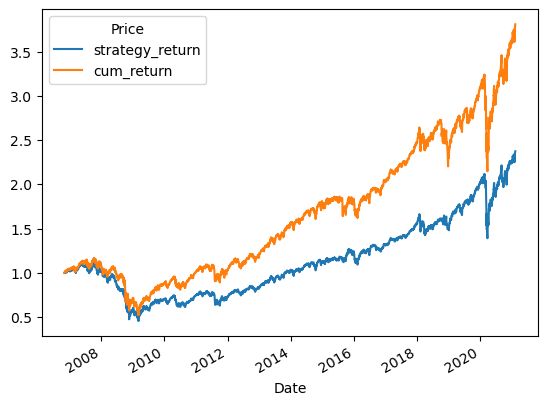

In [ ]:
a[['strategy_return','cum_return']].plot()

- Prof's momentum strat
- Range breakout momentum

#### Mean-Reversion Strategy

### Part 2

build functions/ class to calculate

### Part 3

Write executive summary of strategies and backtesting results

#### Stategy A

#### Strategy B

#### Strategy C

### Part 4

self critique of trading strategy